In [16]:
import osmnx as ox
from shapely.geometry import box
from shapely.geometry import Point
from scipy.spatial import cKDTree
import numpy as np
import geopandas as gpd
import pandas as pd
import momepy
import matplotlib.pyplot as plt
import networkx as nx

In [17]:
# Load data
structured = gpd.read_file("../cairo_data/NewCairo_structured.gpkg")
unstructured = gpd.read_file("../cairo_data/NewCairo_unstructured.gpkg")

In [18]:
# Convert to local UTM if not already
structured_utm = structured.to_crs("EPSG:32636")
unstructured_utm = unstructured.to_crs("EPSG:32636")

# convert to EPSG:4326 for bbox calculation
structured_wgs = structured.to_crs("EPSG:4326")
unstructured_wgs = unstructured.to_crs("EPSG:4326")

In [19]:
# Combine & get bounding box
combined = structured_wgs.geometry.unary_union.union(unstructured_wgs.geometry.unary_union)
minx, miny, maxx, maxy = combined.bounds
bbox_polygon = box(minx, miny, maxx, maxy)

C:\Users\david\AppData\Local\Temp\ipykernel_11824\588238965.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  combined = structured_wgs.geometry.unary_union.union(unstructured_wgs.geometry.unary_union)


In [20]:
# Download OSM network
G = ox.graph_from_polygon(bbox_polygon, network_type = "all", truncate_by_edge = True)

In [21]:
# Convert to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

In [22]:
# # Safe to disk
# ox.save_graphml(G, "data/network_cairo.graphml")
# edges.to_file("data/cairo_edges.gpkg", layer="edges", driver="GPKG")
# nodes.to_file("data/cairo_nodes.gpkg", layer="nodes", driver="GPKG")

In [23]:
# # Load from disk
# G = ox.load_graphml("data/network_cairo.graphml")
# edges = gpd.read_file("data/cairo_edges.gpkg", layer="edges")
# nodes = gpd.read_file("data/cairo_nodes.gpkg", layer="nodes")

In [24]:
# Reproject network to match building data
edges = edges.to_crs("EPSG:32636")
nodes = nodes.to_crs("EPSG:32636")

In [25]:
# Concatenate buildings dataset
structured_utm['type'] = 'structured'
unstructured_utm['type'] = 'unstructured'
buildings_utm = pd.concat([structured_utm, unstructured_utm])

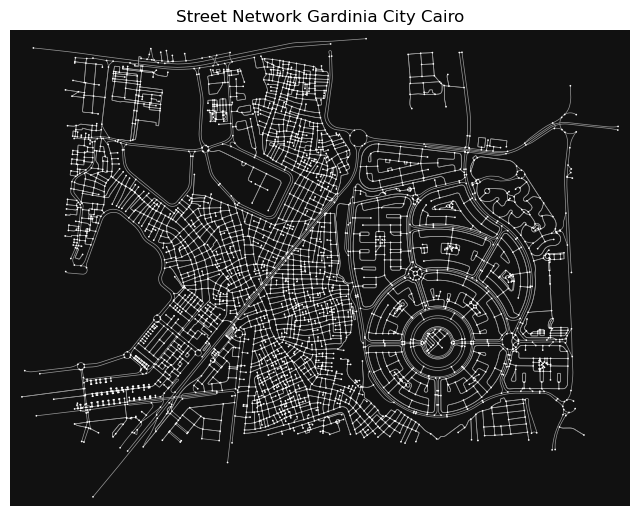

In [40]:
# Plot the street network graph
fig, ax = ox.plot_graph(G, node_size=1.5, edge_linewidth=0.5, show=False)
plt.title("Street Network Gardinia City Cairo")
plt.show()

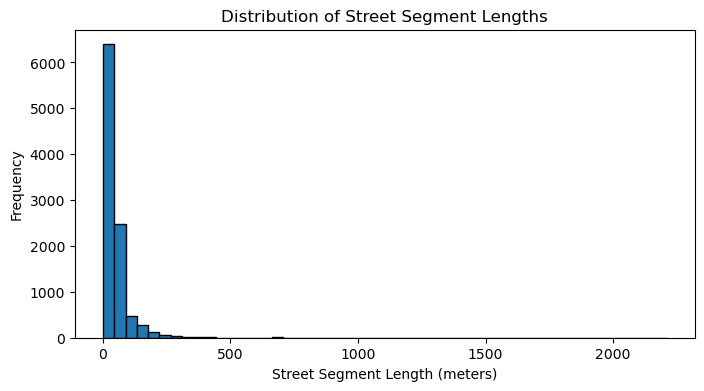

In [27]:
# # Plot distribution of street segment lengths
# edges = ox.graph_to_gdfs(G, nodes=False)
# plt.figure(figsize=(8,4))
# plt.hist(edges['length'], bins=50, edgecolor='k')
# plt.xlabel("Street Segment Length (meters)")
# plt.ylabel("Frequency")
# plt.title("Distribution of Street Segment Lengths")
# plt.show()

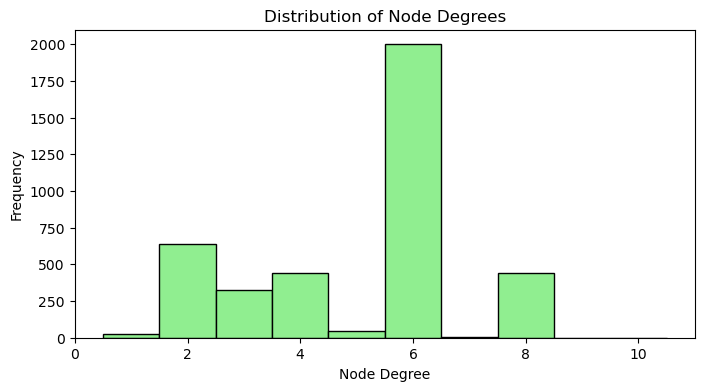

In [28]:
# # 3. Plot histogram of node degrees
# degrees = [d for n, d in G.degree()]
# plt.figure(figsize=(8,4))
# plt.hist(degrees, bins=range(1, max(degrees)+2), align='left', color='lightgreen', edgecolor='k')
# plt.xlabel("Node Degree")
# plt.ylabel("Frequency")
# plt.title("Distribution of Node Degrees")
# plt.show()

In [29]:
# Calculate and plot betweenness centrality
betweenness = nx.betweenness_centrality(G, weight='length', normalized=True)
nx.set_node_attributes(G, betweenness, 'betweenness')

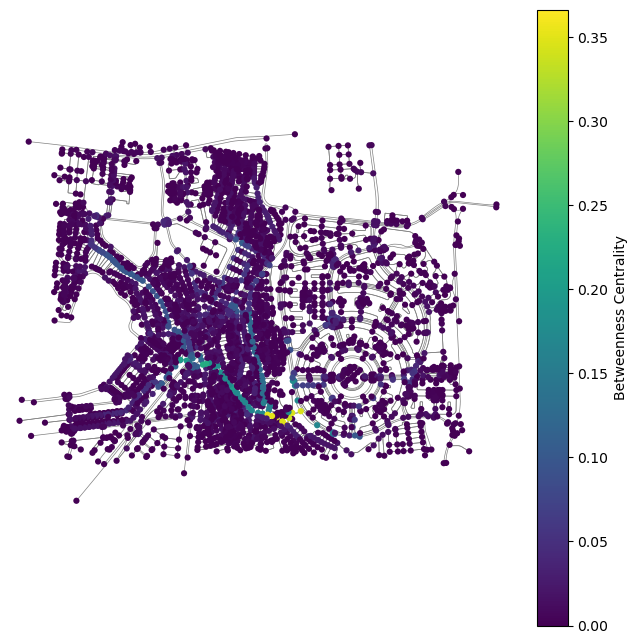

In [46]:
# Plot graph with node color representing betweenness centrality
colors = ox.plot.get_node_colors_by_attr(G, attr="betweenness", cmap="viridis")
fig, ax = ox.plot_graph(
    G, 
    node_size=20, 
    node_color=colors.values, 
    edge_color='gray', 
    edge_linewidth=0.5, 
    bgcolor='white',
    show=False
)
sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=min(betweenness.values()), vmax=max(betweenness.values())))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Betweenness Centrality")

plt.savefig("figure/betweenness_centrality_map.jpg", dpi=300, bbox_inches='tight', facecolor='white', transparent=False)

plt.show()

In [32]:
# Extract nodes and edges with betweenness values and safe to disk
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
nodes['betweenness'] = nodes.index.map(betweenness)
nodes.to_file("data/nodes_with_betweenness.gpkg", driver="GPKG")

In [33]:
# Get GDF of buildings dataset in UTM
combined_utm = pd.concat([structured_utm, unstructured_utm], ignore_index=True)

In [34]:
# Get the centroids as coordinates
combined_utm['centroid'] = combined_utm.geometry.centroid
coords = np.array([(geom.x, geom.y) for geom in combined_utm['centroid']])

In [35]:
# Build KDTree for spatial lookup
tree = cKDTree(coords)

# Query the nearest neighbor
distances, indices = tree.query(coords, k=2)

# Calculate the distance to the nearest neighbor
combined_utm['nearest_dist_m'] = distances[:, 1]

In [37]:
# Separate buildings and centroids
buildings_utm = combined_utm.drop(columns = ["centroid"])
centroids_utm = combined_utm.drop(columns = ["geometry"]).set_geometry("centroid")

In [38]:
buildings_utm.to_file("../cairo_data/buildings_utm.gpkg", layer="buildings", driver="GPKG")
centroids_utm.to_file("../cairo_data/centroids_utm.gpkg", layer="centroids", driver="GPKG")